# This notebook will be used particularly for the Capstone Project

## <b><u>Introduction</b></u>
In the recent months, the majority of the international community is facing with the enormous outbreak of the COVID-19 pandemic when one of the most common tactics among many authorities around the world for decreasing the disease's rate of expansion is closing temporarily public places and institutions in order to ensure the social distancing as much as possible.

Particularly, many schools and educational institutions are closed to this method and the consequences of this action are serious and problematic – many students are staying at home and having gaps in the study material, many teachers and educators are practically unemployed and the parents of the students are struggling between managing their work and taking care of their children. This problem is becoming more challenging when it comes to exit strategy from the virus. Although the setting of the educational system back to normal is definitely important, reckless and irresponsible process of returning of huge amount of students might enlarge the virus' spread again among the society.

Therefore, in order to monitor between the needs of reactivating the schools and keeping the people safe from the virus, I created a model that can help the decision makers of cities and even larger authorities to determine which schools in their jurisdiction are safer to be back in action and by methods of clustering set the basics for a more controlled for releasing the entire educational system after the lockdown.

<center><img src="corona2.png" width=200 height=200></center>

In [1]:
#Libraries for the model

#Importing Pandas and Numpy libraries to the notebook
import pandas as pd
import numpy as np

#Importing Requests library for reading the API urls.
import requests

#Importing JSON library as well as json_normalize for converting JSON files to dataframes.
import json
from pandas.io.json import json_normalize

#Import folium for representing the data and its research's results.
import folium

# Install seaborn
!conda install -c anaconda seaborn --yes

# Import library
import seaborn as sns

#Import the KMeans model function for clustering the data.
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          48 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    dbus-1.13.14               |       hb2f20db_0         590 KB  anaconda
    gst-plugins-base-1.14.0    |       hbbd80ab_1         4.8 MB
    gstreamer-1.14.0           |       hb453b48_1         3.1 MB
    matplotlib-3.1.3           |           py36_0          21 KB  anaconda
    matplotlib-base-3.1.3      |   py36hef1b27d_0         6.6 MB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    pandas-1.0.3               |   py36h0573a6f_0    

In [2]:
%matplotlib inline 

#Importing the matplotlib library
import matplotlib as mpl
import matplotlib.pyplot as plt

In [1]:
#Variables for accessing the Foursquare API (Full code is hidden due to privacy issues)

#CLIENT_ID = ... Foursquare ID
#CLIENT_SECRET = ... Foursquare Secret
#VERSION = '20180604'
#LIMIT = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [96]:
CLIENT_ID = '1RLSNV01JXY1U5UUOZZHUIEONNPZ1VLJIDNPX2WDHWOQO4DF' # your Foursquare ID
CLIENT_SECRET = 'Y0O4RXHRIIQQZN1XYFG1ZTD1ZJAZ2B20NW42H1H10TKKD0TU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1RLSNV01JXY1U5UUOZZHUIEONNPZ1VLJIDNPX2WDHWOQO4DF
CLIENT_SECRET:Y0O4RXHRIIQQZN1XYFG1ZTD1ZJAZ2B20NW42H1H10TKKD0TU


## <b><u>Data</u></b>
For this model, I chose to focus on the data that's related to the schools and the high schools of New York City.
I chose this city since its area has the largest amount of known coronavirus cases in the USA and probably in the entire world. I arranged the schools' data in the model's database based on the following features:

1.	Name of School, Neighborhood and Borough – In order to get the list of schools in NYC, I used the same database which was introduced in Assignment 3,derived from the link https://geo.nyu.edu/catalog/nyu_2451_34572 , which has the information about the lat-lon locations of each neighborhood in the city. By that data, I used the Foursquare API explore method to scroll over the neighborhoods and scrap the basic information of each school in NYC while filtering the venues for the relevant categories ("School", "High School", "Religious School" and etc.)
2.	Latitude and Longitude of the school – By the process that was mentioned in section 1, I could also retrieve the lat-lon locations of each school in the database.
3.	The Zip Code Area of the school and its amount of Coronavirus Cases Per 1000 people – Based on the map and the CSV data which are introduced in the article: "Coronavirus in New York City, Tracking the spread of the pandemic", link: https://projects.thecity.nyc/2020_03_covid-19-tracker/.
<br> CSV files for zip code lat-lon locations and the cases for zip code – at my Github repository:
https://github.com/Avichai1125/Coursera_Capstone/blob/master/uszips.csv
https://github.com/Avichai1125/Coursera_Capstone/blob/master/cases_per_zip.csv
4.	The composition of the neighboring venues near the school – The model assumes that schools are likely to be opened at the last stages of the exit strategy, and therefore examining the types of the closest venues to the school's area is a good key for examining the risk of the virus' relapse after the school reactivation. The venues will be retrieved by the Foursquare API explore method and they will be counted and divided into main groups based on their categories, each represented by a column in the database: Restaurants, Shops and Stores, Outdoor Venues, Religious Sites, Other Indoor Venues.
5.	The Risk Factor – A weighted sum of the features mentioned in the sections of 3 and 4 which represents the level of risk at re-opening the school. The weights will be determined by the importance of each factor to the risk itself when a high weight represents a higher threat.



In [97]:
#Getting the data for the neighborhoods of New York City.

!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
#Representing the NYC neighborhood's data as a dataframe.

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
neighborhoods_data = newyork_data['features']

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [8]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### <center><u>Functions for arranging the relevant data in the dataframe</u></center>

In [3]:
#Function for retrieving the list of the NYC schools along with their lat-lon coordinates.
#The function scrolls over the basic NYC neighborhoods' dataframe and for each neighborhood gets the relevant data
#using Foursquare API.

def CreateNYSchoolDatabase(nydata, radius=500):
    boroughs = nydata['Borough']
    neighs = nydata['Neighborhood']
    latitude = nydata['Latitude']
    longitude = nydata['Longitude']
    
    venues_list=[]
    for boro, nei, lat, lng in zip(boroughs, neighs, latitude, longitude):
        print(nei +', '+boro) #Ensuring the API works for each iteration.
        link = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            "School", #Setting a query "School" for exculding non relevant data
            500, 
            LIMIT)
            
        # make the GET request
        results = requests.get(link).json()["response"]['groups'][0]['items']
        
        #Ensuring that the given data will be as focused as possible by filtering the venues according to a set
        #of relevant categories.
        relcat = ['School','Elementary School','High School','Middle School','Preschool','Private School','Religious School']
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                scCategory = v['venue']['categories'][0]['name']
            except:
                if "school" in v['venue']['name'].lower():
                    scCategory = "School"
                else:
                    scCategory = "Unknown"
            
            if scCategory in relcat:
                venues_list.append((v['venue']['name'],
                                    boro,
                                    nei,
                                    v['venue']['location']['lat'],
                                    v['venue']['location']['lng'],
                                    scCategory))
    ny_columns = ['School','Borough','Neighborhood','Latitude','Longitude','Category']
    ny_schools = pd.DataFrame(venues_list,columns = ny_columns)
    
    
    return(ny_schools)

In [9]:
#Function that outputs for each school its closest venues' categories for analyzing its environment for the model.
#The function scrolls over the schools' lat-lon coordinates and retrieve the venues' categories by the Foursquare API
#The function define the radius of search for the venues and the starting row in the database for collecting the data.
#Maximum venues for each school: 30.(=LIMIT)

def getNearbyCategories(nysc, radius=200, st=0):
    latitudes = nysc['Latitude'][st:]
    longitudes = nysc['Longitude'][st:]
    schoolNames = nysc['School'][st:]
    borNames = nysc['Borough'][st:]
    neiNames = nysc['Neighborhood'][st:]
    
    categ_list=[]
    counter = 0
    for lat, lng, name, boro, nei in zip(latitudes, longitudes, schoolNames, borNames, neiNames):
        print(name+', '+nei+', '+boro) #Ensuring the API works for each iteration.
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            #The data that the API can supply is limited per day.
            #This line of code informs the user at which iteration the API stopped working.
            print("The scraping stopped at index "+ str(st+counter))
            break
            
        
        # return only relevant information for each nearby venue
        categ_list.append([v['venue']['categories'][0]['name'] for v in results])
        counter = counter + 1
            
    return categ_list

In [13]:
#The previous function returns a list of all the nearby venues categories' lists for the NYC schools. In order to use
#this information for determining the risk factor for each school, the following function will convert each one of the lists
#to a numeric value counts vector.

#The output will be a dataframe where the columns are the full list of the categories of the venues that were found close
#to the NYC schools while the rows will be the lists in the value counts format.

#For Example, if the categories of the closest venues of the 20th school in the database are 
# ['Gym','Israeli Restaurant','Gym','Park','Park'], the output will represent the list as:
#       Gym ... Israeli Restaurant ... Park
# 20    2               1                2

def data_orginizer(lst): 
    #Summing up all the relevant categories as mentioned above.
    lstVals = set()
    for l in lst:
        lstVals = lstVals | set(l)

    lstVals = sorted(list(lstVals)) #Sort the categories alphabetically
    
    #Creating the counters for each category, as a part of converting the categories' data into the vector count format.
    dictCount = dict()
    counters = [[0 for i in range(len(lst))] for j in range(len(lstVals))]
    dictCount.update(zip(lstVals,counters))
    
    for n in range(len(lst)):
        for name in lst[n]:
            dictCount[name][n] += 1
    
    #Creating the output dataframe
    outdf = pd.DataFrame(dictCount,columns = lstVals)
    return outdf

In [36]:
# Functions for determining the "cases per 1000" value for each school in the database.

from math import radians, cos, sin, asin, sqrt

# The first function computes the distance between two given lat-lon loctaions 
def DistLatLon(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

#The second function matches for each school the zip code area it's into, and by that returns for it
#its cases per 1000 values.

def ZipCodeForSchool(nydata,zcdf):
    latitudes = nydata['Latitude']
    longitudes = nydata['Longitude']
    casesDensity = []
    closestZipCodes = []
    for nowlat, nowlon in zip(latitudes,longitudes):
        #Computing the distances between the school and lat-lon coordinates of the zip-code areas.
        distList = [(DistLatLon(nowlat,nowlon,zcdf.loc[ind,'Latitude'],zcdf.loc[ind,'Longitude']),zcdf.loc[ind,'Cases Per 1000'],ind) for ind in zcdf.index]
        czip = min(distList)
        casesDensity.append(czip[1])
        closestZipCodes.append(czip[2])
    
    return casesDensity,closestZipCodes

In [2]:
#Function that set a risk factor column in a database according to a given weights vector and
#relevant features for computing the risk.

def add_risk_column(df,columns,risk_weights):
    #Ensuring that the lengths of the features and the weights are the same.
    if len(risk_weights)<len(columns):
        risk_weights = risk_weights+(len(columns)-len(risk_weights))*[1]
        
    df['Risk Factor'] = np.asarray(df[columns]).dot(np.transpose(np.array(risk_weights)))

### <center><u>Full process of creating the database for the model</u></center>

<b>Creating the  basic database of the NYC schools.</b><br>
Based on the function CreateNYSchoolDatabase, the neighborhoods dataframe will be expanded for the school data.

In [18]:
nysc = CreateNYSchoolDatabase(neighborhoods, radius=500)
nysc.shape
nysc.head()

Wakefield, Bronx
Co-op City, Bronx
Eastchester, Bronx
Fieldston, Bronx
Riverdale, Bronx
Kingsbridge, Bronx
Marble Hill, Manhattan
Woodlawn, Bronx
Norwood, Bronx
Williamsbridge, Bronx
Baychester, Bronx
Pelham Parkway, Bronx
City Island, Bronx
Bedford Park, Bronx
University Heights, Bronx
Morris Heights, Bronx
Fordham, Bronx
East Tremont, Bronx
West Farms, Bronx
High  Bridge, Bronx
Melrose, Bronx
Mott Haven, Bronx
Port Morris, Bronx
Longwood, Bronx
Hunts Point, Bronx
Morrisania, Bronx
Soundview, Bronx
Clason Point, Bronx
Throgs Neck, Bronx
Country Club, Bronx
Parkchester, Bronx
Westchester Square, Bronx
Van Nest, Bronx
Morris Park, Bronx
Belmont, Bronx
Spuyten Duyvil, Bronx
North Riverdale, Bronx
Pelham Bay, Bronx
Schuylerville, Bronx
Edgewater Park, Bronx
Castle Hill, Bronx
Olinville, Bronx
Pelham Gardens, Bronx
Concourse, Bronx
Unionport, Bronx
Edenwald, Bronx
Bay Ridge, Brooklyn
Bensonhurst, Brooklyn
Sunset Park, Brooklyn
Greenpoint, Brooklyn
Gravesend, Brooklyn
Brighton Beach, Brookl

School Borough Neighborhood   Latitude  Longitude  \
0                 Public School 87   Bronx    Wakefield  40.895487 -73.846004   
1                           MS 181   Bronx   Co-op City  40.874980 -73.831202   
2                          PS 176x   Bronx   Co-op City  40.875268 -73.832776   
3  PS 178 Dr Selman Waksman School   Bronx   Co-op City  40.874697 -73.833070   
4                           PS 178   Bronx   Co-op City  40.875154 -73.833091   

  Category  
0   School  
1   School  
2   School  
3   School  
4   School

In [5]:
#The shape of the basic NYC school dataframe is:
nysc.shape

(1556, 6)

<b>Creating the "Cases Per 1000" column.</b><br>
As mentioned before, the data acquisition for that column will based on two csv databases: the first one is the
full list of the USA zip codes numbers (updated to April 2020).

In [21]:
nyzdf = pd.read_csv('uszips.csv')
nyzdf.head()

zip       lat       lng       city state_id   state_name  zcta  \
0  601  18.18004 -66.75218   Adjuntas       PR  Puerto Rico  True   
1  602  18.36073 -67.17517     Aguada       PR  Puerto Rico  True   
2  603  18.45439 -67.12202  Aguadilla       PR  Puerto Rico  True   
3  606  18.16724 -66.93828    Maricao       PR  Puerto Rico  True   
4  610  18.29032 -67.12243     Anasco       PR  Puerto Rico  True   

   parent_zcta  population  density  county_fips county_name  \
0          NaN       17242    111.4        72001    Adjuntas   
1          NaN       38442    523.5        72003      Aguada   
2          NaN       48814    667.9        72005   Aguadilla   
3          NaN        6437     60.4        72093     Maricao   
4          NaN       27073    312.0        72011      Añasco   

                              county_weights             county_names_all  \
0               {'72001':99.43,'72141':0.57}              Adjuntas|Utuado   
1                              {'72003':100}                       Aguada   
2                              {'72005':100}                    Aguadilla   
3  {'72093':94.88,'72121':1.35,'72153':3.78}  Maricao|Yauco|Sabana Grande   
4               {'72003':0.55,'72011':99.45}                Añasco|Aguada   

     county_fips_all  imprecise  military             timezone  
0        72001|72141      False     False  America/Puerto_Rico  
1              72003      False     False  America/Puerto_Rico  
2              72005      False     False  America/Puerto_Rico  
3  72093|72153|72121      False     False  America/Puerto_Rico  
4        72011|72003      False     False  America/Puerto_Rico

and the second one is a csv database which contains the coronavirus cases per 1000 for each zip code area
in New York City.<br> The data was collected manually according to the interactive map who appeared in The City's article (see section 3 in Data).

In [22]:
cor_cases = pd.read_csv('cases_per_zip.csv')
cor_cases.head()

Zip  Cases Per 1000
0  10001            13.0
1  10002            10.0
2  10003             6.7
3  10004             8.6
4  10005             5.4

For the cor_cases dataframe, we set the "Zip" column as an index and adding the lat-lon data for each zip code area in New York, derived from the uszips database.

In [25]:
nyzdf = nyzdf.set_index('zip')

KeyError: "None of ['zip'] are in the columns"

In [34]:
ziplist = cor_cases['Zip'].values.tolist()
ziplat = [nyzdf.loc[nyz,'lat'] for nyz in ziplist]
ziplon = [nyzdf.loc[nyz,'lng'] for nyz in ziplist]
cor_cases['Latitude'] = ziplat
cor_cases['Longitude'] = ziplon
cor_cases = cor_cases.set_index('Zip')
cor_cases.head()

Cases Per 1000  Latitude  Longitude
Zip                                       
10001            13.0  40.75061  -73.99716
10002            10.0  40.71586  -73.98613
10003             6.7  40.73180  -73.98911
10004             8.6  40.69465  -74.02106
10005             5.4  40.70616  -74.00907

Using the ZipCodeForSchool function for matching each school to its corresponding zip code area and cases per 1000 value.<br>
The results will be added to model's dataframe.

In [39]:
casesDensity, sczip = ZipCodeForSchool(nysc,cor_cases)

In [40]:
nysc['Zip Code'] = sczip
nysc['Cases_Per_1000'] = casesDensity

In [42]:
nysc.head()
nysc.to_csv('nysc.csv')

In [3]:
nysc = pd.read_csv('nysc.csv')
nysc = nysc.drop(['Unnamed: 0'],axis=1)
nysc.head()

School Borough Neighborhood   Latitude  Longitude  \
0                 Public School 87   Bronx    Wakefield  40.895487 -73.846004   
1                           MS 181   Bronx   Co-op City  40.874980 -73.831202   
2                          PS 176x   Bronx   Co-op City  40.875268 -73.832776   
3  PS 178 Dr Selman Waksman School   Bronx   Co-op City  40.874697 -73.833070   
4                           PS 178   Bronx   Co-op City  40.875154 -73.833091   

  Category  Zip Code  Cases_Per_1000  
0   School     10466            26.0  
1   School     10475            33.0  
2   School     10475            33.0  
3   School     10475            33.0  
4   School     10475            33.0

<b>Creating the nearby venues related columns</b><br>
As mentioned before, the getNearbyCategories function returns for each school its closest venues categories' list.

In [15]:
ctlist = getNearbyCategories(nysc,radius = 200) #st = 0

The scraping stopped at index 950


You can see that the function stopped working at 950th row of the dataframe since it passed the amount of the possible Foursquare API queries that can be asked per day. Therefore, we store the achieved information in a csv file database (nearby_storage) and complete the process at the next day.

In [33]:
ctstore = pd.DataFrame(ctlist) 
ctstore.to_csv('nearby_storage.csv') 

Second part of collecting the nearby venues data

In [10]:
ctlist2 = getNearbyCategories(nysc,radius = 200,st = 950) #Starting where we stopped yesterday.

Epiphany School, Gramercy, Manhattan
P.S. 40, Gramercy, Manhattan
Botox Training Manhattan, Gramercy, Manhattan
American School Of Sign Language, Gramercy, Manhattan
P.S. 47, Gramercy, Manhattan
Salk School Of Science, Gramercy, Manhattan
Learning Spring Academy, Gramercy, Manhattan
LearningSpring School, Gramercy, Manhattan
InsideOut Executive Coaching LLC, Gramercy, Manhattan
Kumon Math and Reading Center of Gramercy Park, Gramercy, Manhattan
NY Kids Club - 3rd Avenue, Gramercy, Manhattan
Ecole Internationale de New York, Gramercy, Manhattan
The American Sign Language & English Secondary School, Gramercy, Manhattan
47 ASL HS, Gramercy, Manhattan
47 American Sign Language High School, Gramercy, Manhattan
School Of The Future High School, Gramercy, Manhattan
Simon Baruch Middle School, Gramercy, Manhattan
PS 347, Gramercy, Manhattan
Simon Baruch M.S 104, Gramercy, Manhattan
Junior High School 104, Gramercy, Manhattan
ICE Institute Of Collabarative Education, Gramercy, Manhattan
Prescho

Achieving the entire nearby venues' data for the NYC schools

In [61]:
#Combining between the nearby data that was achieved during the last two days.
old_ns = pd.read_csv('nearby_storage.csv') #uploading the nearby_storage csv to the notebook.
old_ns = old_ns.drop(['Unnamed: 0'],axis=1)
old_ns = old_ns.append(ctlist2) #Adding the second day information to complete the process.

#Changing the NaN values in the dataframe into 'NO' strings.
old_ns = old_ns.reset_index()
old_ns = old_ns.drop(['index'],axis=1)
old_ns = old_ns.fillna('NO')

In [64]:
old_ns.to_csv('nearby_storage.csv')

In [6]:
fullNearby = pd.read_csv('nearby_storage.csv')
fullNearby = fullNearby.drop(['Unnamed: 0'],axis=1)
fullNearby

0                     1             2             3  \
0                NO                    NO            NO            NO   
1                NO                    NO            NO            NO   
2                NO                    NO            NO            NO   
3                NO                    NO            NO            NO   
4                NO                    NO            NO            NO   
...             ...                   ...           ...           ...   
1551        Theater  Gym / Fitness Center      Building          Café   
1552    Art Gallery  Gym / Fitness Center   Supermarket       Theater   
1553          Beach                    NO            NO            NO   
1554          Beach                 Beach  Burger Joint  Neighborhood   
1555  Deli / Bodega                    NO            NO            NO   

                        4                     5                     6  \
0                      NO                    NO                    NO   
1                      NO                    NO                    NO   
2                      NO                    NO                    NO   
3                      NO                    NO                    NO   
4                      NO                    NO                    NO   
...                   ...                   ...                   ...   
1551  Sporting Goods Shop  Gym / Fitness Center               Theater   
1552   Italian Restaurant   American Restaurant  Caucasian Restaurant   
1553                   NO                    NO                    NO   
1554  Fried Chicken Joint           Bus Station            Shoe Store   
1555                   NO                    NO                    NO   

                         7                8                       9  ... 27.1  \
0                       NO               NO                      NO  ...   NO   
1                       NO               NO                      NO  ...   NO   
2                       NO               NO                      NO  ...   NO   
3                       NO               NO                      NO  ...   NO   
4                       NO               NO                      NO  ...   NO   
...                    ...              ...                     ...  ...  ...   
1551            Sports Bar            Hotel              Food Court  ...   NO   
1552  Gym / Fitness Center  Thai Restaurant  Furniture / Home Store  ...   NO   
1553                    NO               NO                      NO  ...   NO   
1554              Bus Stop            Beach              Food Truck  ...   NO   
1555                    NO               NO                      NO  ...   NO   

     28.1 29.1          3.1                         4.1            5.1   6.1  \
0      NO   NO  Gas Station  Construction & Landscaping  Deli / Bodega  Food   
1      NO   NO           NO                          NO             NO    NO   
2      NO   NO           NO                          NO             NO    NO   
3      NO   NO           NO                          NO             NO    NO   
4      NO   NO           NO                          NO             NO    NO   
...   ...  ...          ...                         ...            ...   ...   
1551   NO   NO           NO                          NO             NO    NO   
1552   NO   NO           NO                          NO             NO    NO   
1553   NO   NO           NO                          NO             NO    NO   
1554   NO   NO           NO                          NO             NO    NO   
1555   NO   NO           NO                          NO             NO    NO   

     7.1 8.1 9.1  
0     NO  NO  NO  
1     NO  NO  NO  
2     NO  NO  NO  
3     NO  NO  NO  
4     NO  NO  NO  
...   ..  ..  ..  
1551  NO  NO  NO  
1552  NO  NO  NO  
1553  NO  NO  NO  
1554  NO  NO  NO  
1555  NO  NO  NO  

[1556 rows x 60 columns]

In [71]:
catlist = []
#Getting the full list of nearby venue categories' list for each NYC schools.
#Each row of the dataframe will be converted to a list and be cleaned from its 'NO' values.
for i in fullNearby.index:
    catlist.append([x for x in fullNearby.loc[i,:].values.tolist() if x != 'NO'])
    
#The first values of the output will be:

[['Dessert Shop',
  'Pharmacy',
  'Pharmacy',
  'Gas Station',
  'Construction & Landscaping',
  'Deli / Bodega',
  'Food'],
 ['Pizza Place', 'Baseball Field', 'Bus Station'],
 ['Baseball Field', 'Bus Station'],
 ['Baseball Field', 'Bus Station'],
 ['Baseball Field', 'Bus Station']]

After we got the full list of the nearby venues categories' lists for the NYC schools, we use the data_orginizer function to arrange those lists in form of dataframe where every list is represented by its corresponding value counts vector.

In [76]:
ct_df = data_orginizer(catlist)

In [83]:
ct_df.to_csv('school_cat.csv')

In [7]:
ct_df=pd.read_csv('school_cat.csv')
ct_df = ct_df.drop(['Unnamed: 0'],axis=1)

Accessories Store  Adult Boutique  Afghan Restaurant  \
0                     0               0                  0   
1                     0               0                  0   
2                     0               0                  0   
3                     0               0                  0   
4                     0               0                  0   
...                 ...             ...                ...   
1551                  0               0                  0   
1552                  0               0                  0   
1553                  0               0                  0   
1554                  0               0                  0   
1555                  0               0                  0   

      African Restaurant  Airport Terminal  American Restaurant  \
0                      0                 0                    0   
1                      0                 0                    0   
2                      0                 0                    0   
3                      0                 0                    0   
4                      0                 0                    0   
...                  ...               ...                  ...   
1551                   0                 0                    0   
1552                   0                 0                    1   
1553                   0                 0                    0   
1554                   0                 0                    0   
1555                   0                 0                    0   

      Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  ...  \
0                  0             0       0                 0  ...   
1                  0             0       0                 0  ...   
2                  0             0       0                 0  ...   
3                  0             0       0                 0  ...   
4                  0             0       0                 0  ...   
...              ...           ...     ...               ...  ...   
1551               0             0       0                 0  ...   
1552               0             0       0                 0  ...   
1553               0             0       0                 0  ...   
1554               0             0       0                 0  ...   
1555               0             0       0                 0  ...   

      Video Game Store  Video Store  Vietnamese Restaurant  Watch Shop  \
0                    0            0                      0           0   
1                    0            0                      0           0   
2                    0            0                      0           0   
3                    0            0                      0           0   
4                    0            0                      0           0   
...                ...          ...                    ...         ...   
1551                 0            0                      0           0   
1552                 0            0                      0           0   
1553                 0            0                      0           0   
1554                 0            0                      0           0   
1555                 0            0                      0           0   

      Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0              0         0          0            0              0            0  
1              0         0          0            0              0            0  
2              0         0          0            0              0            0  
3              0         0          0            0              0            0  
4              0         0          0            0              0            0  
...          ...       ...        ...          ...            ...          ...  
1551           0         0          0            0              0            0  
1552           0         0          0            0              0            0  
1553     

In [12]:
#Example for the 20th school in the dataframe
example = ct_df.loc[20,:]
example = example[example!=0] #Excluding venues who aren't close to the school
example

American Restaurant     1
Café                    1
Candy Store             1
Caribbean Restaurant    1
Coffee Shop             1
Department Store        1
Discount Store          1
Donut Shop              2
Gym                     2
Ice Cream Shop          1
Mexican Restaurant      1
Miscellaneous Shop      1
Pizza Place             2
Sandwich Place          3
Seafood Restaurant      1
Spanish Restaurant      1
Steakhouse              1
Supermarket             2
Supplement Shop         1
Yoga Studio             1
Name: 20, dtype: int64

We see that there are 418 categories of venues that can be found around the schools and in order to simplify the examining the composition of each school's environment, we will divide the basic categories into 6 main groups:
Restaurants, Shops and Stores, Outdoor Venues, Religious Sites and Other Indoor Venues.

The process of setting the groups will be based on sorting the categories by finding keywords and manually adding of categories by context.

In [64]:
cols = ct_df.columns.values.tolist() #Full list of the categories
Restaurants = [] 
Shops = []
Outdoor = [] #Outdoor Venues
Religious = [] #Religious Sites
Other = [] #Other Indoor Venues
Unclass = [] #Categories who remain unclassified after sorting by keywords

#Sorting categories by keywords
for nc in cols:
    #"Caf" - for Cafe,Cafeteria and etc.
    if ("Restaurant" in nc) | ("Place" in nc) | ("Caf" in nc) | ('Joint' in nc):
        Restaurants.append(nc)
    elif ("Shop" in nc) | ("Store" in nc) | ("Boutique" in nc) | ("market" in nc.lower()):
        Shops.append(nc)
    elif ("Park" in nc) | ("Field" in nc) | ("Trail" in nc):
        Outdoor.append(nc)
    elif ("Bar" in nc) | ("College" in nc) | ("Club" in nc) | ("Gym" in nc) | ("Studio" in nc) | ("Office" in nc) | ("Service" in nc):
        Other.append(nc)
    else:
        Unclass.append(nc)

#Sorting the remaining unclassified categories manaully
Religious += ['Church','Spiritual Center','Synagogue','Temple']
Shops += ['Bakery','Bookstore','Butcher','Drugstore','Dry Cleaner','Food Court','Laundromat',
          'Organic Grocery','Pharmacy','Rest Area','Shoe Repair']
Restaurants += ['Beer Garden','Bistro','Breakfast Spot','Buffet','Cha Chaan Teng','Creperie','Deli / Bodega','Diner',
                'Food','Food Stand','Food Truck','Noodle House','Steakhouse','Tea Room']
Outdoor += ['Airport Terminal','Beach','Border Crossing','Bridge','Bus Line','Bus Station','Bus Stop','Circus','Dog Run',
            'Farm','Fountain','Garden','Garden Center','Gas Station','Golf Course','Harbor / Marina','Heliport',
            'Historic Site','Intersection','Lake','Light Rail Station','Memorial Site','Mini Golf','Monument / Landmark',
            'Neighborhood','Other Great Outdoors','Outdoor Sculpture','Outdoors & Recreation','Pedestrian Plaza','Pier',
            'Platform','Playground','Plaza','Pool','Public Art','Racetrack','River','Road','Rock Climbing Spot',
            'Scenic Lookout','Sculpture Garden','Street Art','Tennis Court','Track','Train Station']

Other += [u for u in Unclass if u not in Religious + Shops + Restaurants + Outdoor]

In [79]:
#Creating a dataframe for the 6 main groups of venues' categories.
MainCategories = dict()
MainCategories['Restaurants'] = Restaurants
MainCategories['Shops And Stores'] = Shops
MainCategories['Outdoor Venues'] = Outdoor
MainCategories['Religious Sites'] = Religious
MainCategories['Other Indoor Venues'] = Other

ct_df_simp = pd.DataFrame(columns = MainCategories.keys())
for ct_name in MainCategories.keys():
    #Summing the categories' data for each group.
    ct_df_simp[ct_name] = sum([ct_df[sub] for sub in MainCategories[ct_name]])

#Complete sizes of the categories.
ct_df_simp.sum()

Restaurants            8233
Shops And Stores       5843
Outdoor Venues         1175
Religious Sites          11
Other Indoor Venues    4985
dtype: int64

In [83]:
#Adding the main categories' dataframe into the model's dataframe.
nysc_full = pd.concat([nysc,ct_df_simp],axis=1)

In [84]:
nysc_full.head()

School Borough Neighborhood   Latitude  Longitude  \
0                 Public School 87   Bronx    Wakefield  40.895487 -73.846004   
1                           MS 181   Bronx   Co-op City  40.874980 -73.831202   
2                          PS 176x   Bronx   Co-op City  40.875268 -73.832776   
3  PS 178 Dr Selman Waksman School   Bronx   Co-op City  40.874697 -73.833070   
4                           PS 178   Bronx   Co-op City  40.875154 -73.833091   

  Category  Zip Code  Cases_Per_1000  Restaurants  Shops And Stores  \
0   School     10466            26.0            2                 3   
1   School     10475            33.0            1                 0   
2   School     10475            33.0            0                 0   
3   School     10475            33.0            0                 0   
4   School     10475            33.0            0                 0   

   Outdoor Venues  Religious Sites  Other Indoor Venues  
0               1                0                    1  
1               2                0                    0  
2               2                0                    0  
3               2                0                    0  
4               2                0                    0

<b>Adding the "Risk Factor" column</b><br>
After we got the full information about the frequency of the coronavirus cases among the society and the composition of venues around the NYC schools, we can finally add a risk factor based those features and self-defined weights for each one of them.

In [88]:
#Relevant features for the risk factor
colsForRisk = ['Cases_Per_1000','Restaurants','Shops And Stores','Outdoor Venues','Religious Sites','Other Indoor Venues']

#Weights for computing the risk factor
risk_weights = [1,2.5,2,0.8,2.5,1]

#Adding the risk column into the model's dataframe, resulting its final form.
add_risk_column(nysc_full,colsForRisk,risk_weights)
nysc_full.head()

School Borough Neighborhood   Latitude  Longitude  \
0                 Public School 87   Bronx    Wakefield  40.895487 -73.846004   
1                           MS 181   Bronx   Co-op City  40.874980 -73.831202   
2                          PS 176x   Bronx   Co-op City  40.875268 -73.832776   
3  PS 178 Dr Selman Waksman School   Bronx   Co-op City  40.874697 -73.833070   
4                           PS 178   Bronx   Co-op City  40.875154 -73.833091   

  Category  Zip Code  Cases_Per_1000  Restaurants  Shops And Stores  \
0   School     10466            26.0            2                 3   
1   School     10475            33.0            1                 0   
2   School     10475            33.0            0                 0   
3   School     10475            33.0            0                 0   
4   School     10475            33.0            0                 0   

   Outdoor Venues  Religious Sites  Other Indoor Venues  Risk Factor  
0               1                0                    1         38.8  
1               2                0                    0         37.1  
2               2                0                    0         34.6  
3               2                0                    0         34.6  
4               2                0                    0         34.6

In [93]:
nysc_full.to_csv('nysc_full.csv')

## <b><u>Exploratory Data Analysis</u></b>

<b>Choosing weights for the risk factor</b><br>
As seen in the Data segment, the weights that were chosen for defining the risk factor aren't equally balanced and varied between 0.8 and 2.5. Considerations that led for determining the weights include:<br>
1.	Restaurants, shops and stores had the largest weight value since their approachability to the age sections of minor schoolers and high-schoolers is the highest among the other main categories.
2.	Religious sites are also paired with high weight due to the fact that they were proven to be a common crowding spots that unfortunately became prominent centers for the virus to spread.
3.	Outdoor venues however, have a slightly lower than 1 value of weight according to the current perception in the scientific community that the rate of expansion of the COVID-19 virus is decreased in open spaces.
4.	The remaining indoor venues received a neutral weight with a value of 1, due to their span of their types and the fact that a huge part of this group isn't relevant and sometimes prohibited for minor activity (such as gyms, bars and clubs).
5.	Same weight value of 1 was also set for the cases per 1000 feature due to its high mean value compared to the other features and by that to assure its dominancy in the risk factor's essence. 

In [2]:
risk_weights = [1,2.5,2,0.8,2.5,1]

<b>Overall distribution of the venues' categories</b><br>
1.	 In order to examine the distribution of the values of the risk factor's components in the school's database, I created a box plot for a visual comparison between them, as seen below.
2.	By the box plot's chart, we can see that except from the CP1000 and the Restaurants, all the other features have high number of outliers in their distributions. The reason for this difference is probably due to the fact that the definitions of these features are more general than the other two.
3.	Also, the Restaurants and Shops and Stores features have similar ranges of values, proving that the partition of the entire indoor venues' categories is balanced for the model. However, the Outdoor Venues and Religious Sites features have low mean values and therefore share a small part in the venues' data. 
4.	Despite the high amount of the outliers of the risk factor's components, the risk factor's distribution has few of them and thus seems a reliable measure for the model.

In [35]:
nysc_full = pd.read_csv('nysc_full.csv')
nysc_full = nysc_full.drop(['Unnamed: 0'],axis=1)

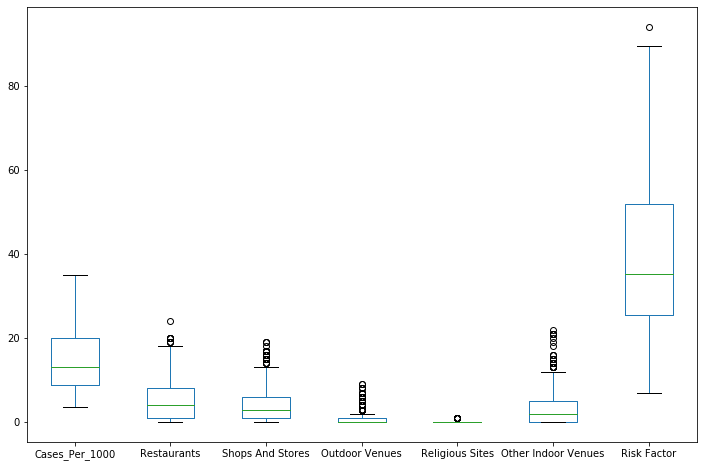

In [34]:
env_cols = ['Cases_Per_1000','Restaurants','Shops And Stores','Outdoor Venues','Religious Sites',
            'Other Indoor Venues','Risk Factor']
nysc_env = nysc_full[env_cols]
nysc_env.plot(kind='box', figsize=(12, 8))

<b>Relationship between the Cases Per 1000 feature and the risk factor</b><br>
One assumption that would likely be taken into consideration is there's a strong correlation between the incidence of coronavirus in the school's area (or particularly to our model, its zip code area), demonstrated by the Cases Per 1000, and the risk factor for the school reactivation.

In order to test this assumption, I subtracted the "Cases_Per_1000" feature's part from the risk factor and computed for each of the possible CP1000 values the average for the reduced risk factor values. Then, I created a regression plot for finding the correlation's behavior between the CP1000 values and their corresponding average risk values and the result can be shown below.

In [43]:
nysc_reg = nysc_full[['Cases_Per_1000','Risk Factor']]
NoCasesRisk = nysc_reg['Risk Factor'] - nysc_reg['Cases_Per_1000']
nysc_reg['Average Risk Factor (Reduced)'] = NoCasesRisk
nr2 = nysc_reg.groupby(['Cases_Per_1000']).mean()
nr2 = nr2.reset_index()
nr2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Cases_Per_1000  Risk Factor  Average Risk Factor (Reduced)
0             3.7    30.700000                      27.000000
1             4.6    45.062500                      40.462500
2             5.4    35.450000                      30.050000
3             5.7    53.925000                      48.225000
4             6.4    49.471875                      43.071875

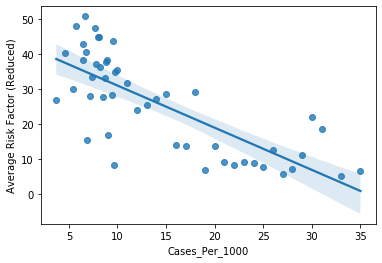

In [44]:
ax = sns.regplot(x='Cases_Per_1000', y='Average Risk Factor (Reduced)', data=nr2)

The graph proves the assumption and it demonstrated a strong correlation between those variables, however, the correlation is surprisingly negative. This is probably caused by the fact that the remaining reduced risk factor is based on the venues' data, and since the places with the highest CP1000 values are mostly located in the outskirts and in the poor borough of Bronx, area with lack of places of entertainment, the risk in those areas from the venues is getting lower.

Therefore, it seems that the full risk factor balances pretty well between these sub-factors.

## <b><u>Analyzing the Data by the Model</u></b><br>
During the process of the data preparation it became more clearly to see that the chosen features for analyzing the schools in New York City for the model, can be divided into main groups: geographical features – latitude, longitude, borough, neighborhood and zip code and environmental features – cases per 1000, restaurants, shops and stores, outdoor venues, religious sites, and other indoor venues. <br>

Therefore, in order to have proper insights for setting the key points of the schools' reactivation process, we need to examine  the interactions between the geographical and the environmental concepts of the data's features as well as analyzing each of their influences on the risk factor. <br>

For that matter, the analysis, as it performed by the model, will have three main parts:
1.	<u>Analyzing the relationship between the geographical features and the risk factor:</u><br> By applying the K-means algorithm over the data of the lat-lon coordinates, we will test the dependency of the risk factor based on the geographical location of the school.<br><br> Since the population of New York City is divided in 5 main boroughs, we set the number of clusters as K=5 in order to have a more realistic and easy understanding results for the decision makers.

In [7]:
# set number of clusters
kclusters = 5

loc_clustering = nysc_full[['Latitude','Longitude']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(loc_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, ..., 4, 4, 2], dtype=int32)

In [16]:
print(kmeans.cluster_centers_) #cluster centers

[[ 40.74649573 -73.97824708]
 [ 40.84487711 -73.89419133]
 [ 40.59591806 -74.12511403]
 [ 40.66818392 -73.95985838]
 [ 40.71320918 -73.81438323]]


In [5]:
nysc_full['Location Labels'] = kmeans.labels_ #Adding the location labels' data into the dataframe

2.	<u>Analyzing the relationship between the environmental features and the risk factor:</u><br> By applying the K-means algorithm over the environmental features we'll be able to find complex characteristics of the schools' area based on the composition of their surrounding venues. In that case, the objective is to detect special cases and phenomena that might be taken into considering in the reactivation process as well as their effects on the risk factor.<br><br> Since there are 5 features for describing the venues' distribution, we set the number of clusters as K=5 for assuring that each feature for the most will have a dominant influence in one of the resulting types.

In [21]:
from sklearn.preprocessing import StandardScaler

# set number of clusters
kclusters2 = 5

comp_mat = np.asarray(nysc_full[['Cases_Per_1000','Restaurants','Shops And Stores','Outdoor Venues',
                                'Religious Sites','Other Indoor Venues']])

comp_clustering = StandardScaler().fit_transform(comp_mat) #Normalize the data for better results.

comp_clustering
# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(comp_clustering)

#check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [27]:
print(kmeans2.cluster_centers_) #cluster_centers

[[-0.85985127  0.04474027  0.13294853  2.88243202 -0.08437856  0.73337323]
 [ 1.13620645 -0.76748283 -0.72764285 -0.17424275 -0.08437856 -0.73438704]
 [-0.64459604  1.07095286  1.02781555 -0.18135606 -0.08437856  0.87601134]
 [-0.53750461  0.16710383  0.55132382 -0.17438648 11.85135205  0.47592792]
 [-0.44327704 -0.32187759 -0.35019881 -0.21121043 -0.08437856 -0.29587704]]


In [28]:
nysc_full['Comp Labels'] = kmeans2.labels_ #Adding the venues' composition labels' data into the dataframe

In [30]:
nysc_full.to_csv('nysc_full.csv')

In [3]:
#Full model's dataframe including the labels' data.
nysc_full = pd.read_csv('nysc_full.csv')
nysc_full = nysc_full.drop(['Unnamed: 0'],axis=1)
nysc_full.head()

School Borough Neighborhood   Latitude  Longitude  \
0                 Public School 87   Bronx    Wakefield  40.895487 -73.846004   
1                           MS 181   Bronx   Co-op City  40.874980 -73.831202   
2                          PS 176x   Bronx   Co-op City  40.875268 -73.832776   
3  PS 178 Dr Selman Waksman School   Bronx   Co-op City  40.874697 -73.833070   
4                           PS 178   Bronx   Co-op City  40.875154 -73.833091   

  Category  Zip Code  Cases_Per_1000  Restaurants  Shops And Stores  \
0   School     10466            26.0            2                 3   
1   School     10475            33.0            1                 0   
2   School     10475            33.0            0                 0   
3   School     10475            33.0            0                 0   
4   School     10475            33.0            0                 0   

   Outdoor Venues  Religious Sites  Other Indoor Venues  Risk Factor  \
0               1                0                    1         38.8   
1               2                0                    0         37.1   
2               2                0                    0         34.6   
3               2                0                    0         34.6   
4               2                0                    0         34.6   

   Location Labels  Comp Labels  
0                1            1  
1                1            1  
2                1            1  
3                1            1  
4                1            1

3.	<u>Analyzing the connection between the environmental and the geographical features</u><br> By the knowledge that was earned in the two previous parts of the model and by using statistical methods, we will examine the correlation between the environmental and the geographical according to the two different types of labeling we offered for each school.<br><br>

### <center><u>Functions for analyzing the results of the model</u></center>

In [4]:
#Function that displays the NYC schools' location in New York City's map
#based on their clusters' partition (Location or composition labels)

#lat-lon location of New York City's center.
nylat = 40.7127281
nylon= -74.0060152

#Import matplotlib commands for the color scheme of the markers.
import matplotlib.cm as cm
import matplotlib.colors as colors

def map_for_clustering(df,LabelCol):
    map_clusters = folium.Map(location=[nylat, nylon], zoom_start=10)
    
    # set color scheme for the clusters
    colors_array = cm.rainbow(np.linspace(0, 1, 5))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    for lat, lon, school, zipc, boro, neigh, cluster in zip(df['Latitude'], df['Longitude'], df['School'], df['Zip Code'], df['Borough'], df['Neighborhood'], df[LabelCol]):
        text = folium.Popup(str(school) +', '+str(boro)+', '+str(neigh)+', '+ str(zipc)+'. Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=text,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    
    return map_clusters

In [5]:
#Function that inputs a given label data (location or composition) and returns a dataframe with the following
#statistical incides for each one of the clusters: the label's num, the cluster's size, the mean values of the features
#and the risk factor, standard deviation of the lat-lon information (for reviewing the span of the cluster's components),
#the partition of the cluster's components among the New York City's boroughs and the neighborhood with the highest
#number of components of the cluster.

def show_statistics(df,typeLabel):
    cols = ['Label','Cluster Size','Bronx','Brooklyn','Manhattan','Staten Island','Queens','Top Neighborhood',
                         'Latitude Mean','Latitude STD','Longitude Mean','Longitude STD','Cases_Per_1000','Restaurants',
                         'Shops And Stores','Outdoor Venues','Religious Sites','Other Indoor Venues','Risk Factor']
    stat_labels = pd.DataFrame(columns=cols)
    
    for i in range(5):
        clusterData = df[df[typeLabel]==i]
        desc_label = clusterData.describe(include='all')
        boroCount = clusterData['Borough'].value_counts()
        stat_labels.loc[i,'Label'] = i+1
        stat_labels.loc[i,'Cluster Size'] = desc_label.loc['count','School']
        for b in ['Bronx','Brooklyn','Manhattan','Staten Island','Queens']:
            try:
                stat_labels.loc[i,b] = boroCount[b]
            except:
                stat_labels.loc[i,b] = 0
        
        stat_labels.loc[i,'Top Neighborhood'] = desc_label.loc['top','Neighborhood']
        stat_labels.loc[i,'Latitude Mean'] = desc_label.loc['mean','Latitude']
        stat_labels.loc[i,'Latitude STD'] = desc_label.loc['std','Latitude']
        stat_labels.loc[i,'Longitude Mean'] = desc_label.loc['mean','Longitude']
        stat_labels.loc[i,'Longitude STD'] = desc_label.loc['std','Longitude']
        
        for cm in ['Cases_Per_1000','Restaurants','Shops And Stores','Outdoor Venues','Religious Sites','Other Indoor Venues','Risk Factor']:
            stat_labels.loc[i,cm]=desc_label.loc['mean',cm]
        
    return stat_labels
        

In [6]:
#Function that inputs a given label data (location or composition) and returns a risk-factored orderred dataframe
#for the entire NYC schools or for schools in a specific cluster. The function can also print the dataframe's content
#and by that option it can serve as a tool for the New York's decision to examine directly the risk data of the schools.

def show_order(df,typeLabel,lnum,ascend=False,print_res=True):
    if typeLabel=='All':
        df_out = df.sort_values('Risk Factor',ascending = ascend) #False - lowest to highest, True - highest to lowest
    else:
        df_out = df[df[typeLabel]==lnum-1].sort_values('Risk Factor',ascending = ascend)
    
    if print_res==True:
        counter = 1
        print('Ordered list of the schools with the '+'highest'*(not ascend)+'lowest'*(ascend)+' risk:')
        for i in df_out.index:
            rowInf = ', '.join([df.loc[i,c] for c in ['School','Borough','Neighborhood']])
            labelInf = ', Location Label: '+str(df.loc[i,'Location Labels']+1)+', Comp Label: '+str(df.loc[i,'Comp Labels']+1)
            RiskInf = ', Risk Factor: '+str(df.loc[i,'Risk Factor'])
            print(str(counter)+'. '+rowInf+labelInf+RiskInf)
            counter = counter+1
    
    return df_out

## <b><u>Results</u></b>

<b>Analysis of the risk factor based on geographical features (location labels)</b>

In [5]:
#The distribution of the location clusters in New York City
map_for_clustering(nysc_full,'Location Labels')

#if the map isn't shown on the notebook, enter this link
#https://github.com/Avichai1125/Coursera_Capstone/blob/master/ny1.PNG

<center>
<u>Legend</u><br>
<b><font style="color:#8000ff">Label 1</font></b>,<b><font style="color:#00b5eb"> Label 2</font></b>,<b><font style="color:#80ffb4"> Label 3</font></b>,<b><font style="color:#ffb360"> Label 4</font></b>,<b><font style="color:#ff0000"> Label 5</font></b>
</center>

In [17]:
#Exploratory data of the location clusters
slloc = show_statistics(nysc_full,'Location Labels').set_index('Label')

In [19]:
slloc.transpose()

Label                          1           2              3            4  \
Cluster Size                 649         301             72          358   
Bronx                          0         239              0            0   
Brooklyn                      34           0              1          353   
Manhattan                    579          58              0            0   
Staten Island                  0           0             71            0   
Queens                        36           4              0            5   
Top Neighborhood     East Harlem  Morrisania  Tompkinsville  Boerum Hill   
Latitude Mean            40.7465     40.8449        40.5959      40.6682   
Latitude STD           0.0270676   0.0245274      0.0365428    0.0300619   
Longitude Mean          -73.9782    -73.8942       -74.1251     -73.9599   
Longitude STD          0.0217996   0.0347936      0.0476901    0.0332348   
Cases_Per_1000             9.647     21.3987        24.2917      13.4374   
Restaurants              7.94145     3.02658        1.59722      4.18436   
Shops And Stores         5.49615     1.88704       0.847222       3.4581   
Outdoor Venues            1.0077    0.598007       0.486111     0.564246   
Religious Sites       0.00924499           0              0   0.00837989   
Other Indoor Venues      5.55932     1.08306       0.513889      2.38547   
Risk Factor              46.8815     34.3007        30.8819      33.6723   

Label                        5  
Cluster Size               176  
Bronx                        0  
Brooklyn                     8  
Manhattan                    0  
Staten Island                0  
Queens                     168  
Top Neighborhood     Rego Park  
Latitude Mean          40.7132  
Latitude STD         0.0477948  
Longitude Mean        -73.8144  
Longitude STD         0.045128  
Cases_Per_1000         20.6818  
Restaurants            3.15341  
Shops And Stores       2.32386  
Outdoor Venues        0.590909  
Religious Sites      0.0113636  
Other Indoor Venues   0.909091  
Risk Factor            34.6233

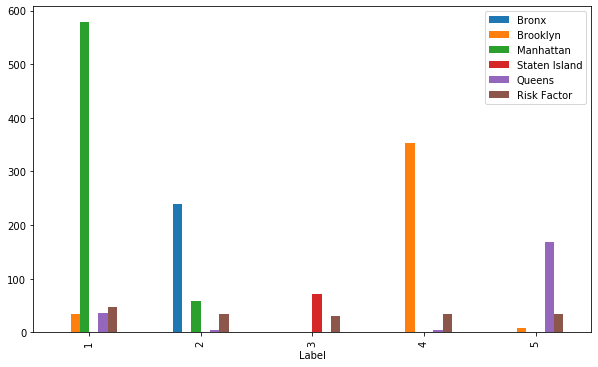

In [23]:
#Plotting a bar chart for examining the connection between the location clusters and the boroughs of NYC.
sllocBar = slloc[['Bronx','Brooklyn','Manhattan','Staten Island','Queens','Risk Factor']]
sllocBar
sllocBar.plot(kind='bar', figsize=(10, 6))

Same with the motive of choosing the number of the clusters, the map and the chart demonstrate the strong connection between the labels and the boroughs of NYC. Label 1 is focused on Manhattan, label 2 on Bronx, label 3 on Staten Island, label 4 on Brooklyn and label 5 on Queens. 

The highest mean value of the risk factor among the labels belongs to label 1 (46.8815) while in other clusters the value is around 35, fact that imply about Manhattan being a very challenging place for the schools' reactivation procedure. That claim can also be confirmed by looking the venues' data of label 1 where the mean values of environmental features are significantly higher that the other labels.

On the other hand, Staten Island is shown to be the least dangerous place for the reactivation procedure due its low risk factor value, in contrast to its high CP1000 value, proving the negative correlation we examined between this value and the risk factor.

<b>Analysis of the risk factor based on environmental features (composition labels)</b>

In [6]:
#The distribution of the venues' composition clusters in New York City
map_for_clustering(nysc_full,'Comp Labels')

#if the map isn't shown on the notebook, enter this link:
#https://github.com/Avichai1125/Coursera_Capstone/blob/master/ny2.PNG

<center>
<u>Legend</u><br>
<b><font style="color:#8000ff">Label 1</font></b>,<b><font style="color:#00b5eb"> Label 2</font></b>,<b><font style="color:#80ffb4"> Label 3</font></b>,<b><font style="color:#ffb360"> Label 4</font></b>,<b><font style="color:#ff0000"> Label 5</font></b>
</center>

In [27]:
#Exploratory data of the composition clusters
slcomp = show_statistics(nysc_full,'Comp Labels').set_index('Label')

In [28]:
slcomp.transpose()

Label                                 1           2              3  \
Cluster Size                         95         526            499   
Bronx                                 2         217             12   
Brooklyn                             14          96            112   
Manhattan                            71          25            348   
Staten Island                         0          70              1   
Queens                                8         118             26   
Top Neighborhood     Financial District  Morrisania  Midtown South   
Latitude Mean                   40.7393     40.7416        40.7393   
Latitude STD                  0.0422661    0.104357      0.0444934   
Longitude Mean                  -73.973    -73.9122       -73.9716   
Longitude STD                 0.0515442    0.100392      0.0385996   
Cases_Per_1000                  8.90105     22.4049        10.3573   
Restaurants                     5.50526     1.61787        10.4168   
Shops And Stores                4.25263     1.03232         7.6012   
Outdoor Venues                  4.22105    0.545627       0.537074   
Religious Sites                       0           0              0   
Other Indoor Venues             5.83158    0.572243        6.34269   
Risk Factor                     40.3779      29.523        58.3741   

Label                              4                5  
Cluster Size                      11              425  
Bronx                              0                8  
Brooklyn                           3              171  
Manhattan                          6              187  
Staten Island                      0                0  
Queens                             2               59  
Top Neighborhood     Carroll Gardens  Lower East Side  
Latitude Mean                40.7339          40.7274  
Latitude STD               0.0353402        0.0558987  
Longitude Mean              -73.9617         -73.9514  
Longitude STD              0.0658171        0.0521964  
Cases_Per_1000               11.0818          11.7193  
Restaurants                  6.09091          3.75059  
Shops And Stores             5.81818          2.44471  
Outdoor Venues              0.545455         0.501176  
Religious Sites                    1                0  
Other Indoor Venues          4.90909          2.14353  
Risk Factor                  45.7909          28.5296

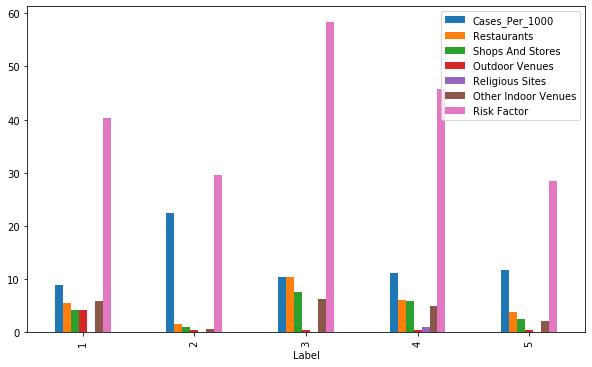

In [32]:
#Plotting a bar chart for examining the venues' data for each of the clusters.
slcompBar = slcomp[['Cases_Per_1000','Restaurants','Shops And Stores','Outdoor Venues','Religious Sites','Other Indoor Venues','Risk Factor']]
slcompBar
slcompBar.plot(kind='bar', figsize=(10, 6))

By analyzing the mean values of the venues' data for each of the labels, compared to the corresponding mean value for the risk factor, we can properly define the sub groups of the NYC schools which the composition labels are referring to:
<ul>
    <li>Comp label 3 - A large cluster of schools with low CP1000 values, but with high amount of restaurants, shops and stores around them, with average risk factor of 58.3741 (the highest).</li>
    <li>Comp label 4 - The smallest cluster among the other of schools with low CP1000 values, but with high presence of restaurants and religious sites, with average risk factor of 45.7909.</li>
    <li>Comp label 1 - A small-medium sized cluster of schools with the lowest CP1000 values among the other labels, but with a significant presence of indoor and outdoor venues around them, with average risk factor of 40.3779.</li>
    <li>Comp label 2 - The largest cluster of among the others of schools with very high CP1000 values and a very low presence of venues' around them, with average risk factor of 29.523.</li>
    <li>Comp label 5 - A very large group of schools with low CP1000 values and low presence of venues around them, with average risk factor of 28.5296 (the lowest).</li>
</ul>

The huge amount of schools with low risk values (labels 2 and 5) can enlarge the operating space and the requested time limit for the reactivation process, but the high standard deviation values of the more problematic clusters (label 3 and label 1) might be a huge obstacle for initiating the plan.

<b>Relationship between the location labels and the composition labels</b><br>
The Pearson correlation coefficient is proven to be pretty close to 0, shown there is no sign of dependency between
the two labeling types.

In [61]:
nylabels = nysc_full[['Location Labels','Comp Labels']]
LabelsCorr = nylabels.corr().loc['Location Labels','Comp Labels']
LabelsCorr

-0.011728599697177041

<u>The partition of the composition labels based on the location labels</u>

In [96]:
#Creating a dataframe for analyzing the partition of the compisition labels for each of the location labels and vice versa.
#For example, the partition of the composition labels for the location label of 1:
nylabels[nylabels['Location Labels'] == 0]['Comp Labels'].value_counts()

2    369
4    180
0     78
1     16
3      6
Name: Comp Labels, dtype: int64

In [10]:
cpldict = dict()
cpldict['Loc 1 - Manhattan']= [78,16,369,6,180] #nylabels[nylabels['Location Labels'] == 0]['Comp Labels'].value_counts()
cpldict['Loc 2 - Bronx']= [5,230,23,0,43] #nylabels[nylabels['Location Labels'] == 1]['Comp Labels'].value_counts()
cpldict['Loc 3 - Staten Island']= [0,70,1,0,1] #nylabels[nylabels['Location Labels'] == 2]['Comp Labels'].value_counts()
cpldict['Loc 4 - Brooklyn'] = [8,91,89,3,167] #nylabels[nylabels['Location Labels'] == 3]['Comp Labels'].value_counts()
cpldict['Loc 5 - Queens'] = [4,119,17,2,34] #nylabels[nylabels['Location Labels'] == 4]['Comp Labels'].value_counts()

CompPerLoc = pd.DataFrame.from_dict(cpldict,orient='index')
CompPerLoc.columns = ['Comp 1','Comp 2','Comp 3','Comp 4','Comp 5']

In [11]:
CompPerLoc

Comp 1  Comp 2  Comp 3  Comp 4  Comp 5
Loc 1 - Manhattan          78      16     369       6     180
Loc 2 - Bronx               5     230      23       0      43
Loc 3 - Staten Island       0      70       1       0       1
Loc 4 - Brooklyn            8      91      89       3     167
Loc 5 - Queens              4     119      17       2      34

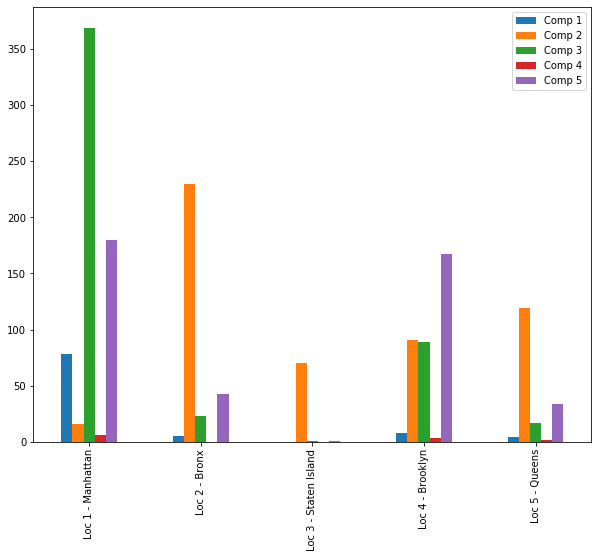

In [13]:
CompPerLoc.plot(kind='bar', figsize=(10, 8))

By looking at this chart along with the geographical span of the composition labels' clusters, it's pretty clear to see that the largest number of high risk labeled schools (labels 1, 3 and 4) are mostly located in Manhattan area and as long as the school is far away from the center of the city, its affiliation with the "safe" clusters (labels 2 and 5) is more common. This tendency can serve the decision makers as a keypoint for determining the order of the schools for reactivation.

<b>Ordering the schools by the risk factor and the distribution of the labels</b><br>
The final model's dataframe can be ordered by the risk factor column and therefore can be a great source of information for the decision makers to scroll over the schools' data meticulously and define the order of the schools to be re-opened. Also, by reviewing the ordered dataframe we can analyze the distribution of the labels as long as the risk factor increases.

In [16]:
#Ordering the schools from the lowest and the highest risk factor
ord_nysc = show_order(nysc_full,'All',1,ascend=True,print_res=False)

In [17]:
ord_nysc.head()

School    Borough     Neighborhood  \
268              MS 442 School For Innovation   Brooklyn  Windsor Terrace   
263  Bishop Ford Central Catholic High School   Brooklyn  Windsor Terrace   
261                    Stanley Lamm Preschool   Brooklyn  Windsor Terrace   
260                                      K280   Brooklyn  Windsor Terrace   
701            Metropolitan Montessori School  Manhattan  Upper West Side   

      Latitude  Longitude       Category  Zip Code  Cases_Per_1000  \
268  40.656063 -73.982186  Middle School     11215             6.9   
263  40.655988 -73.981990    High School     11215             6.9   
261  40.655991 -73.982851         School     11215             6.9   
260  40.656034 -73.982395         School     11215             6.9   
701  40.788676 -73.979004         School     10024             8.8   

     Restaurants  Shops And Stores  Outdoor Venues  Religious Sites  \
268            0                 0               0                0   
263            0                 0               0                0   
261            0                 0               0                0   
260            0                 0               0                0   
701            0                 0               0                0   

     Other Indoor Venues  Risk Factor  Location Labels  Comp Labels  
268                    0          6.9                3            4  
263                    0          6.9                3            4  
261                    1          7.9                3            4  
260                    1          7.9                3            4  
701                    0          8.8                0            4

In [34]:
ordLocLabels = ord_nysc[['Location Labels']].values.transpose().tolist()[0]
ordCompLabels = ord_nysc[['Comp Labels']].values.transpose().tolist()[0]

In [40]:
ordComp4 = [int(ocl==4) for ocl in ordCompLabels]
csOrd = np.cumsum(ordComp4)

In [75]:
#Create line plot for the labels occurences along the increase in the risk factor
def create_line_plot(ordl,label_names):
    pltlineDict = dict()
    for i in range(5):
        csOrd = np.cumsum([int(ol==i) for ol in ordl]).tolist()
        pltlineDict[label_names[i]] = csOrd
    
    pltDf = pd.DataFrame.from_dict(pltlineDict)
    pltDf.plot.line(figsize=(10, 8))
    plt.xlabel("Schools' chart indices")
    plt.ylabel("Number of label representatives")

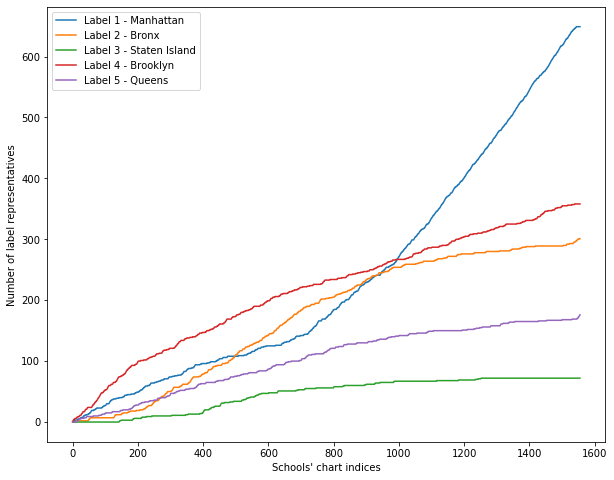

In [77]:
#Line plot for location labels
create_line_plot(ordLocLabels,['Label 1 - Manhattan','Label 2 - Bronx','Label 3 - Staten Island','Label 4 - Brooklyn','Label 5 - Queens'])

The chart shows that the Manhattan related cluster has a decent number of low risk schools while it also has a dominant amount of representatives at the top 600 highest risk schools in NYC. The increase in its growth on list occurs at the same place where the other schools' labels became less common.

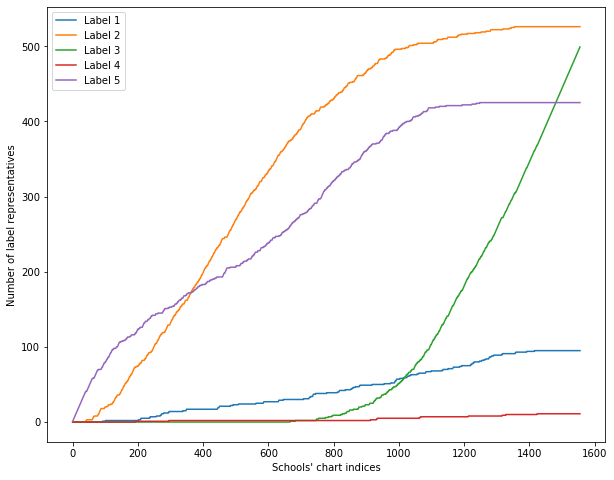

In [79]:
#Line plot for the composition labels
create_line_plot(ordCompLabels,['Label 1','Label 2','Label 3','Label 4','Label 5'])

The chart shows a rapid growth at the presence of schools with comp label of 3 from about the 800th place of the list, while simultaneously the other labels show signs of decreasing.

## <b><u>Conclusions</u></b>

<ol>
    <li>The model's results reveal that there is a contrast between two main factors which probably had the largest effect of the risk factor's determining: The cases per 1000 value and the amount of venues around the schools. Although at first glance these two factors affect each other in a linearly positive relation, the relation itself, as it was depicted by the model, was actually inverse - schools from areas with high CP1000 values were unlikely to have exposure to venues around them (such as Bronx and Staten Island) when on the other hand, schools from areas with low CP1000 values were mostly had a significant amount of venues in a close distance. </li>
    <li>As I mentioned before at the Exploratory Data Analysis segment, this phenomenon is probably caused by external economic factors that increases the CP1000 value and decrease the risk from the venues at the same time (poor conditions, lack of entertainment spots and etc) and even though the risk factor seems to target schools with higher presence of neighboring venues and small CP1000 values as more problematic to be reopened, the decision makers need to focus equally on both of these factors and find the compromise between them at each stage of the reactivation procedure.</li>
    <li>Also, the results indicate the general distribution of the schools based on their risk factor, when the risk is more present at the center of the city (especially at the Manhattan area) and it's getting weaker as long as we move to the outskirts of city. Therefore, this insight gives the decision makers a reliable keypoint for determining the order of the schools to be reopened at the reactivation procedure along with the ordered list of schools that have already derived from the model's results.</li>
    <li>However, following the general direction of the risk levels shouldn't come on the expense of detecting special cases. For example, schools with religious sites around them made up a very small part of the entire data, but in the final results they are considered as a widely spread group with very high risk factor, showing that these kinds of anomalies must be paid attention at the procedure.
</ol>